Load data

In [89]:
from datetime import datetime
import time

def add_speeds(datos):
    dates= datos["date"]
    datos["timestamp"] = 0
    formated = []
    for d in dates:
        formated.append(datetime.strptime(d, "%Y/%m/%d %H:%M:%S").timestamp())   
    datos["timestamp"] = formated
    last_timestamps = datos["timestamp"].shift(1)
    datos['ds'] =  datos["timestamp"]-last_timestamps
    datos['velocidad'] = datos['distance']/datos['ds']
    datos["timestamp"] = datos["timestamp"]/1000000
    return datos.dropna()

In [91]:
import pandas as pd
import numpy as np
import utm
from datetime import datetime

def load_flujo_files(filename):
    datos = pd.read_csv(filename,sep=";")
    datos = datos.iloc[1000:3600] #first 3700 rows have data
    dates = datos["FECHA"]+" "+datos["HORA"]
    formated = []
    for date in dates:
        formated.append(datetime.strptime(date, '%d/%m/%y %H:%M:%S').strftime('%Y/%m/%d %H:%M:%S'))
   
    datos["DATETIME"] = formated
    datos = datos[["DATETIME","LATITUD","LONGITUD","ALTITUD"]]
    datos.dropna(inplace=True)
    datos["LATITUD"] = pd.to_numeric(datos.LATITUD.str.slice(0, 6) + datos.LATITUD.str.slice(7, ))
    datos = datos[datos.LATITUD<0]
    datos["LONGITUD"] = pd.to_numeric(datos.LONGITUD.str.slice(0, 7) + datos.LONGITUD.str.slice(8, ))
    datos = datos[datos.LONGITUD<0]    
    datos = datos[(datos["ALTITUD"]<4000) & (datos["ALTITUD"]>1800)]
    return datos

In [90]:
import pandas as pd
import numpy as np
import utm

def process_data(latitude_array, longitude_array, height_array, date_array, utmzone):
    #1. UTM Coordinates
    min_distance = 0.01
    zone = utmzone.split(" ")
    zonenum = int(zone[0])
    zoneletter = zone[1]
    utms = utm.from_latlon(latitude_array,longitude_array,zonenum,zoneletter) #14Q for Mexico, 17S for Ecuador    
    utm_x = utms[0]
    utm_y = utms[1]
    last_utm_x = utm_x.shift(1) #last observation
    last_utm_y = utm_y.shift(1)
    last_height = height_array.shift(1)
    distances = np.sqrt((utm_x-last_utm_x)**2 + (utm_y-last_utm_y)**2)+min_distance
    slopes = (height_array-last_height)/distances
    sumdistances = np.cumsum(distances)
    
    new_data = pd.DataFrame({"latitude":latitude_array, "longitude":longitude_array,\
                                "height":height_array, "distance":distances, "sum_distance":sumdistances,\
                                "slope":slopes, "date":date_array
                                    })
    return new_data.dropna()

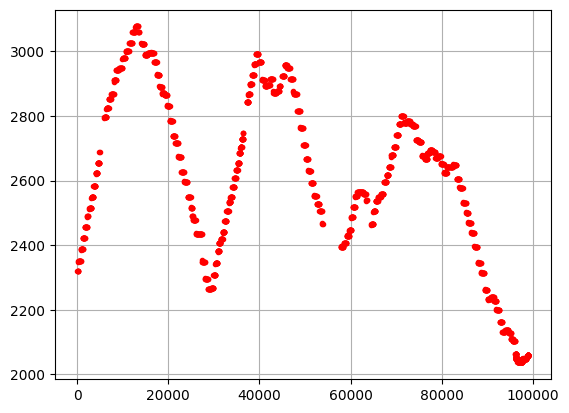

In [92]:
import matplotlib.pyplot as plt

datos = load_flujo_files("datasets/flujo_15_8_2017.csv")
datos = process_data(datos["LATITUD"],datos["LONGITUD"],datos["ALTITUD"],datos["DATETIME"],"17 S")
datos = add_speeds(datos)
datos_l = datos.reset_index(drop=True)
plt.plot(datos_l["sum_distance"],datos_l["height"],"r.")
plt.grid()
plt.show()

Clustering

In [93]:
def sdd_clust(data, tol):
    heights = data["height"]
    clusters = np.ones(len(heights))
    sdd_cluster=1
    dist = 0
    for i in range(1,len(heights)-1):
        dist = abs(heights[i-1]-heights[i])
        if dist>tol:
            sdd_cluster = sdd_cluster+1
        clusters[i] = sdd_cluster  

    data["cluster"] = clusters    
    return data

In [94]:
def tol_adjust (data, tol=1.6): #empezar con tolerance igual al promedio de alturas 
  #entre puntos consecutivos aproximadamente
  n = 1
  while n>0 :
    tol = tol + 0.1
    data2 = sdd_clust(data, tol)
    frec = data2.cluster.value_counts().to_numpy()
    n = frec[frec==1].shape[0] #number of one-single-point clusters
  print('Min gap distance',tol)
  return data2
   


Min gap distance 4.8999999999999995


,latitude,longitude,height,distance,sum_distance,slope,date,timestamp,ds,velocidad,cluster
0,-3.476464,-79.169121,2321.3,32.045666,64.296855,0.000000,2017/08/15 12:08:38,1502.816918,2.0,16.022833,1.0
1,-3.476668,-79.169327,2321.3,32.150962,96.447818,0.000000,2017/08/15 12:08:38,1502.816918,0.0,inf,1.0
2,-3.476898,-79.169502,2321.3,32.028551,128.476369,0.000000,2017/08/15 12:08:40,1502.816920,2.0,16.014276,1.0
3,-3.477153,-79.169647,2321.3,32.489600,160.965969,0.000000,2017/08/15 12:08:42,1502.816922,2.0,16.244800,1.0
4,-3.477430,-79.169754,2321.3,32.870444,193.836413,0.000000,2017/08/15 12:08:44,1502.816924,2.0,16.435222,1.0
5,-3.477718,-79.169830,2321.3,32.960891,226.797304,0.000000,2017/08/15 12:08:46,1502.816926,2.0,16.480446,1.0
6,-3.478016,-79.169914,2349.1,34.262563,261.059867,0.811381,2017/08/15 12:08:48,1502.816928,2.0,17.131281,2.0
7,-3.478322,-79.169991,2350.3,34.915829,295.975695,0.034368,2017/08/15 12:08:50,1502.816930,2.0,17.457914,2.0
8,-3.478796,-79.170120,2350.3,54.354854,350.330550,0.000000,2017/08/15 12:08:53,1502.816933,3.0,18.118285,2.0
9,-3.479121,-79.170212,2350.3,37.377786,387.708336,0.000000,2017/08/15 12:08:55,1502.816935,2.0,18.688893,2.0


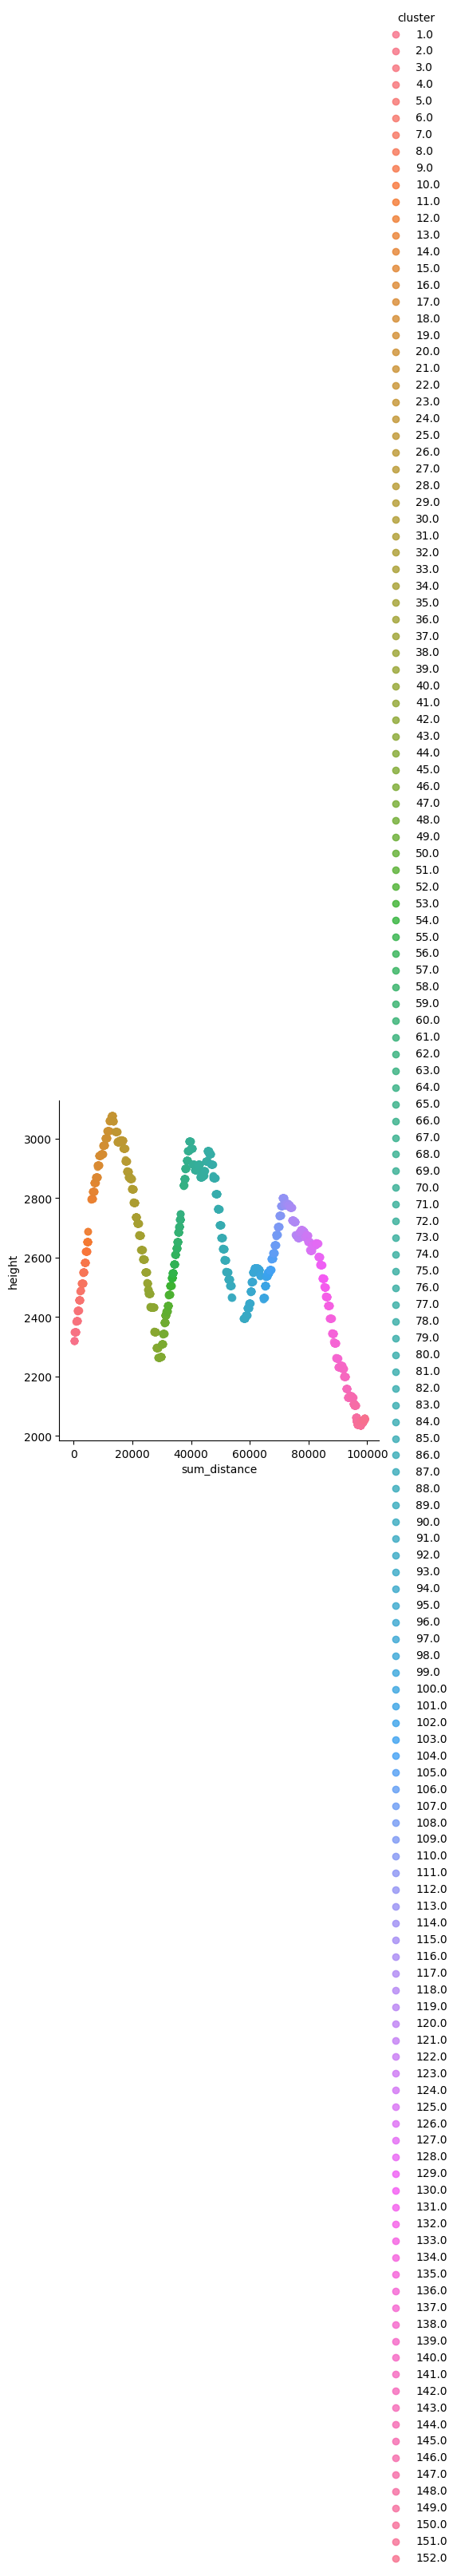

In [95]:
import seaborn as sns

data_clustered = tol_adjust(datos_l, 0.8)
sns.lmplot(x='sum_distance', y='height', data=data_clustered, hue='cluster', fit_reg=False)
data_clustered = data_clustered.reset_index(drop=True)

In [71]:
from sklearn.linear_model import LinearRegression
import math

def height_correction(data_clustered, max_points=5,max_distance=0.5):
    clusters = data_clustered.cluster.unique()
    if(len(clusters)>1):
        gps_smooth = pd.DataFrame()
        for i in range(1,len(clusters)):
            #take pair of clusters
            grupo1 = data_clustered[data_clustered['cluster']==i].copy()
            grupo2 = data_clustered[data_clustered['cluster']==(i+1)].copy()
            m = np.min([grupo1.shape[0],grupo2.shape[0],max_points])

            #take last and first m points  (important to not include borders which are outliers)
            subgrupo1 = grupo1[:-1].tail(m)
            subgrupo2 = grupo2.iloc[2:m]

    
            r = pd.concat([subgrupo1,subgrupo2]).reset_index(drop=True)
            modelo_z = LinearRegression().fit(r[['sum_distance']],r[['height']])
            modelo_x = LinearRegression().fit(r[['sum_distance']],r[['utm_x']])
            modelo_y = LinearRegression().fit(r[['sum_distance']],r[['utm_y']])
            modelo_t = LinearRegression().fit(r[['sum_distance']],r[['timestamp']])
                    
            #200 -100 /5
            #100 200:  100 120 140 160 180 200
            #reemplazar con suavizado
            x_min = r.sum_distance.min()
            x_max = r.sum_distance.max()
            replace_points = math.ceil((r.sum_distance.max()-r.sum_distance.min())/max_distance)

            gap_points = pd.DataFrame({'sum_distance':np.linspace(r.sum_distance.min(),r.sum_distance.max(),replace_points)})

            h_smooth = modelo_z.predict(gap_points[['sum_distance']])                          
            gap_points['height']=h_smooth         
            x_smooth = modelo_x.predict(gap_points[['sum_distance']])
            gap_points['utm_x']=x_smooth
            y_smooth = modelo_y.predict(gap_points[['sum_distance']])
            gap_points['utm_y']=y_smooth  
            t_smooth = modelo_t.predict(gap_points[['sum_distance']])
            gap_points['timestamp']=t_smooth      
            gap_points['secuencia']=0
            gap_points['distance']=0
            gap_points['slope']=0
            gap_points['cluster']=0
            if i==1:
                gps_smooth = pd.concat([gps_smooth,grupo1[0:(grupo1.shape[0] - (m+1))],gap_points])    
            else: 
                gps_smooth = pd.concat([gps_smooth,grupo1[m:(grupo1.shape[0] - (m+1))],gap_points])    
        gps_smooth = pd.concat([gps_smooth,  grupo2[m:(grupo2.shape[0] - (m+1))]])
  
    else:
        print("WARNING: No gaps found (clusters number must be longer than 1")
    datos_l = gps_smooth.copy()
    datos_l["last_utm_x"] = datos_l["utm_x"].shift(1)
    datos_l["last_utm_y"] = datos_l["utm_y"].shift(1)
    datos_l["last_height"] = datos_l["height"].shift(1)
    #calculate distances and slopes
    datos_l["distance"] = np.sqrt((datos_l["utm_x"]-datos_l["last_utm_x"])**2 + (datos_l["utm_y"]-datos_l["last_utm_y"])**2)
    datos_l['distance'] = datos_l['distance'].replace([0], 0.1)
    next_timestamps = datos_l["timestamp"].shift(-1)
    datos_l['ds'] =  next_timestamps-datos_l["timestamp"]
    datos_l['velocidad'] = datos_l['distance']/datos_l['ds']
    datos_l["slope"] = (datos_l["height"]-datos_l["last_height"])/datos_l["distance"] 
    datos_l["sum_distance"] = np.cumsum(datos_l["distance"])
    datos_l = datos_l.tail(-1)
    return(datos_l.reset_index(drop=True))

,TRACK ID,VALID,UTC DATE,UTC TIME,LOCAL DATE,LOCAL TIME,MS,latitud,N/S,longitud,...,slope,sum_distance,timestamp,ds,velocidad,cluster,secuencia,last_utm_x,last_utm_y,last_height
0,1.0,FIXED,2017/5/11,19:13:14,2017/5/11,14:13:14,0.0,2.897703,S,79.022656,...,0.422824,1.291654,1.494548e+09,1.000000,1.291654,1.0,NaN,719792.462339,9.679521e+06,2641.030273
1,1.0,FIXED,2017/5/11,19:13:15,2017/5/11,14:13:15,0.0,2.897692,S,79.022661,...,-0.414135,2.629274,1.494548e+09,-1.568981,-0.852540,1.0,NaN,719793.131469,9.679522e+06,2641.576416
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.403801,4.982528,1.494548e+09,12.568981,0.187227,1.0,0.0,719792.577593,9.679523e+06,2641.022461
3,1.0,FIXED,2017/5/11,19:13:26,2017/5/11,14:13:26,0.0,2.897558,S,79.022632,...,-0.582666,22.481556,1.494548e+09,1.000000,17.499029,2.0,NaN,719792.409804,9.679521e+06,2641.972706
4,1.0,FIXED,2017/5/11,19:13:27,2017/5/11,14:13:27,0.0,2.897555,S,79.022632,...,-0.931539,22.813353,1.494548e+09,1.000000,0.331797,2.0,NaN,719795.828258,9.679538e+06,2631.776611
5,1.0,FIXED,2017/5/11,19:13:28,2017/5/11,14:13:28,0.0,2.897554,S,79.022632,...,-2.083816,22.923952,1.494548e+09,1.000000,0.110599,2.0,NaN,719795.828837,9.679539e+06,2631.467529
6,1.0,FIXED,2017/5/11,19:13:29,2017/5/11,14:13:29,0.0,2.897553,S,79.022632,...,-1.834383,23.034551,1.494548e+09,1.000000,0.110599,2.0,NaN,719795.829030,9.679539e+06,2631.237061
7,1.0,FIXED,2017/5/11,19:13:30,2017/5/11,14:13:30,0.0,2.897551,S,79.022630,...,0.000000,23.348224,1.494548e+09,1.000000,0.313673,2.0,NaN,719795.829223,9.679539e+06,2631.034180
8,1.0,FIXED,2017/5/11,19:13:31,2017/5/11,14:13:31,0.0,2.897551,S,79.022629,...,-0.726717,23.459424,1.494548e+09,1.000000,0.111200,2.0,NaN,719796.052009,9.679539e+06,2631.034180
9,1.0,FIXED,2017/5/11,19:13:32,2017/5/11,14:13:32,0.0,2.897558,S,79.022636,...,0.053594,24.557278,1.494548e+09,1.000000,1.097854,2.0,NaN,719796.163209,9.679539e+06,2630.953369


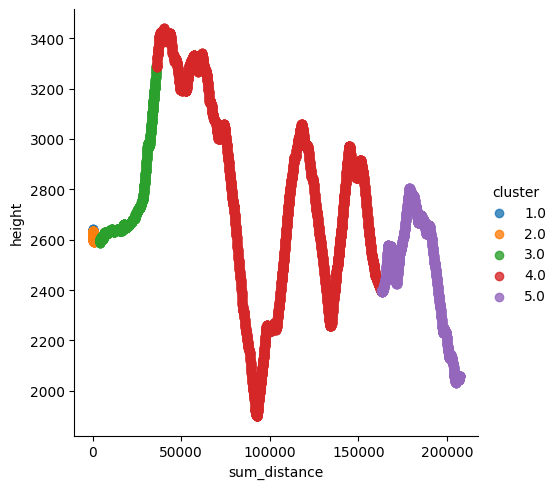

In [72]:
data_smooth = height_correction(data_clustered,10,17)
data_clustered = sdd_clust(data_smooth, 3.5)
sns.lmplot(x='sum_distance', y='height', data=data_clustered, hue='cluster', fit_reg=False)
data_clustered = data_clustered.reset_index(drop=True)
data_clustered.head(20)

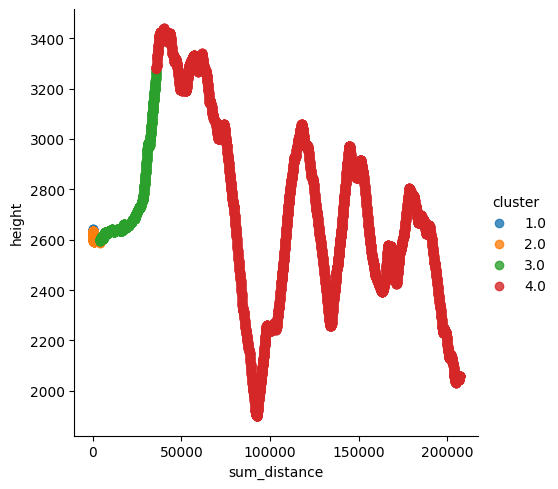

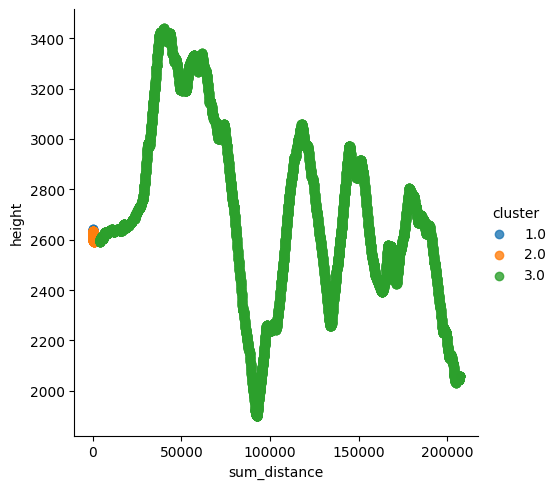

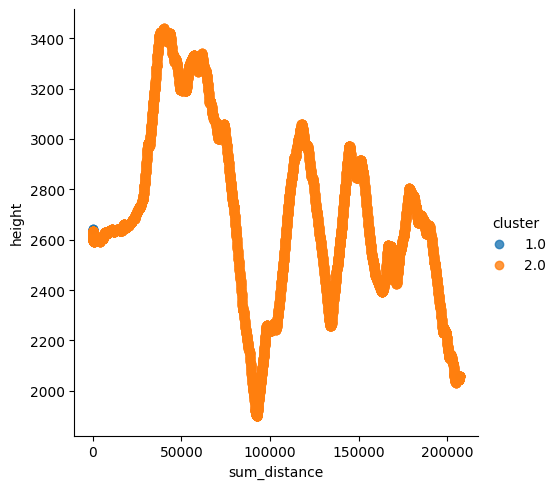

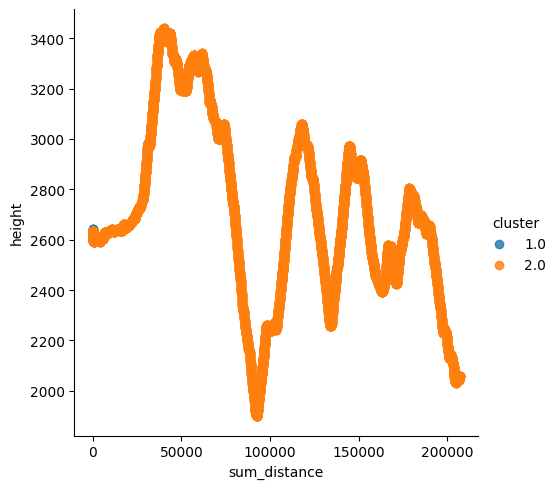

In [73]:
#experimento iterativo, clusterizar -> corregir -> clusterizar -> corregir ....
for i in range(4):
    data_smooth = height_correction(data_clustered,10,17)
    data_clustered = sdd_clust(data_smooth, 3.5)    
    data_clustered = data_clustered.reset_index(drop=True)
    sns.lmplot(x='sum_distance', y='height', data=data_clustered, hue='cluster', fit_reg=False)
data_clustered = data_clustered[["height","utm_x","utm_y","distance","slope","sum_distance","velocidad","timestamp","ds"]]

xs = np.array(data_clustered["utm_x"])
ys = np.array(data_clustered["utm_y"])
utms = utm.to_latlon(xs,ys,17,"S") #14Q for Mexico, 17S for Ecuador
datos_f = data_clustered.copy()
data_clustered["latitud"] = utms[0]
data_clustered["longitud"] = utms[1]
data_clustered.to_csv("datos_corregidos.csv", index=False)
